In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
names = open("names.txt")
lstnames=[]
salphas=set()
i=1
for name in names:
    name = "." + name.rstrip() + "."
    # print(name)
    lstnames.append(name)
    for ch in name:
        salphas.add(ch)
    i=i+1
itos={}
stoi={}
for i,ch in enumerate(sorted(list(salphas))):
    itos[i] = ch
    stoi[ch] = i

In [3]:
tokenlen=3
xs = []
ys=[]
for name in lstnames:
    token = [0]*tokenlen
    # print(name)
    for ch in name[1:]:    
        # print(xs)
        xs.append(token)
        # print(xs)
        x = stoi[ch]
        ys.append(x)        
        
        # print("".join([itos[j] for j in token]),"---->",itos[x])
        token = token.copy()
        token.append(x)
        token = token[1:]
        # print(token)
       
        
        
X = torch.tensor(xs)
Y = torch.tensor(ys)
X.shape

torch.Size([228146, 3])

In [28]:
emb_dim=10
hd_dim = 200
g=torch.Generator().manual_seed(2147483647)
C = torch.randn((27,emb_dim),generator=g)
W1 = torch.randn((emb_dim*tokenlen,hd_dim),generator=g)*(5/3)*((emb_dim*tokenlen)**-0.5) #kaiming normalto make the input to tanh close to zero to avoid dead neurons
b1 = torch.randn(hd_dim,generator=g)*.01
W2 = torch.randn(hd_dim,27,generator=g)*0.01 #initializing to 0 so that the logits are close to zero to allow uniform pdf
b2 = torch.randn(27,generator=g)*0
bngain = torch.ones((1,hd_dim))
bnbias = torch.zeros((1,hd_dim))
bnmean_running = torch.zeros((1,hd_dim))
bnstd_running = torch.ones((1,hd_dim))
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
for p in parameters:
    p.requires_grad = True
n1 = int(round(0.8*X.shape[0],0))
n2 = int(round(0.9*X.shape[0],0))
print(n1)
Xtr = X[:n1,:]
Ytr = Y[:n1]
Xval = X[n1:n2,:]
Yval = Y[n1:n2]
Xtest = X[n2:,:]
Ytest = Y[n2:]

182517


In [30]:
batch_size=32
for i in range(200000):
    # minibatch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    
    emb=C[Xtr[ix]]
    pretanh = emb.view(-1,emb_dim*tokenlen)@W1+b1
    mu = pretanh.mean(dim=0,keepdims=True)
    stddev = pretanh.std(dim=0,keepdims=True)
    bn = bngain*((pretanh-mu)/stddev) + bnbias
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*mu
        bnstd_running = 0.999*bnstd_running + 0.001*stddev
    h = torch.tanh(bn)
    logit = h@W2+b2
    # count = logit.exp()
    # probs = count/count.sum(dim=1,keepdims=True)
    # loss = (-torch.log(probs[torch.arange(32),Y])).mean()
    loss = F.cross_entropy(logit,Ytr[ix])
    if i%10000 == 0:
        print(loss.item())
    # losses.append(loss.item())
    for p in parameters:
        p.grad=None
    loss.backward()
    lr = 0.1 if i<100000 else 0.01
      
    for p in parameters:
        p.data = p.data - lr*p.grad
    
    

3.29803729057312
2.2758889198303223
2.4114441871643066
2.372688055038452
2.0322272777557373
2.0455493927001953
2.0597450733184814
1.8387055397033691
2.1454508304595947
2.030440092086792
1.7051143646240234
2.1847124099731445
2.1237571239471436
2.5836551189422607
2.394392490386963
1.9409312009811401
1.5744235515594482
2.2024662494659424
1.7804793119430542
2.029930591583252


In [32]:
with torch.no_grad():
    emb=C[Xtr]
    pretanh = emb.view(-1,emb_dim*tokenlen)@W1+b1
    mu = pretanh.mean(dim=0,keepdims=True)
    stddev = pretanh.std(dim=0,keepdims=True)
print(mu)    

tensor([[-1.8702e+00,  1.3560e+00, -1.7856e+00,  1.0832e+00,  1.4035e+00,
          1.2563e+00,  2.6796e+00, -9.5656e-01,  7.1771e-01,  1.8791e+00,
         -2.0786e+00, -2.3177e+00, -8.9434e-02, -7.5105e-01,  6.4709e-01,
          6.3841e-01,  1.2378e-01, -2.2673e+00, -3.6692e-01,  1.0780e+00,
         -9.7117e-01, -3.4728e-02, -3.6483e-01,  1.2260e-02,  1.6760e+00,
          7.7025e-01,  1.1301e+00, -1.3506e-02,  8.4149e-01,  2.0046e+00,
          1.4424e-01, -8.0689e-01,  7.5273e-01, -1.8214e-01, -1.7139e+00,
         -6.0897e-01, -1.9139e-01,  1.1007e+00, -1.6204e+00,  5.4913e-01,
         -9.4739e-01, -7.6071e-01, -4.2663e-01,  1.2082e-01,  9.0939e-01,
          1.1902e-01,  1.5177e+00, -1.3837e+00,  1.5899e+00,  1.3656e+00,
          1.2998e+00, -3.7122e-01,  1.2664e+00,  6.8284e-01,  8.1780e-01,
         -3.1853e+00, -7.5850e-01, -3.0278e-01,  1.2362e+00, -1.5285e+00,
         -4.3557e-01,  1.3427e+00,  7.1674e-01, -3.6584e-01,  1.2732e+00,
          1.1371e+00, -5.6195e-01,  1.

In [33]:
bnmean_running

tensor([[-1.8778,  1.3457, -1.7892,  1.0891,  1.4044,  1.2670,  2.6708, -0.9697,
          0.7247,  1.8775, -2.0821, -2.3097, -0.0863, -0.7642,  0.6437,  0.6640,
          0.1377, -2.2645, -0.3748,  1.0916, -0.9611, -0.0340, -0.3612,  0.0201,
          1.6747,  0.7785,  1.1244, -0.0123,  0.8413,  1.9911,  0.1390, -0.7896,
          0.7467, -0.1894, -1.7015, -0.6139, -0.1981,  1.1123, -1.6109,  0.5577,
         -0.9455, -0.7707, -0.4309,  0.1158,  0.9214,  0.1359,  1.5189, -1.3888,
          1.6051,  1.3482,  1.3068, -0.3598,  1.2685,  0.6705,  0.8239, -3.1777,
         -0.7618, -0.3051,  1.2352, -1.5398, -0.4326,  1.3392,  0.7248, -0.3809,
          1.2747,  1.1559, -0.5624,  1.9449, -0.2769, -0.3576, -0.2261,  0.0993,
          0.6373, -1.2974, -1.8918,  1.1511,  1.0259, -0.3981, -0.2064,  0.4716,
         -0.2158,  1.6154,  1.9144,  1.2205,  0.6511, -0.1829, -0.4113, -0.1998,
          2.1823, -0.3851,  0.0047,  0.7977,  1.0980, -0.5502, -0.7917, -0.0196,
         -0.7861, -0.1719, -

In [34]:
#calibrate the mean and stddev

with torch.no_grad():
    emb = C[Xtr]
    pretanh = emb.view(-1,emb_dim*tokenlen)@W1+b1
    bn = bngain*((pretanh-bnmean_running)/bnstd_running) + bnbias
    h=torch.tanh(bn)
    logit = h@W2+b2
    loss = F.cross_entropy(logit,Ytr)
    print(f"training loss = {loss}")
with torch.no_grad():
    emb = C[Xval]
    pretanh = emb.view(-1,emb_dim*tokenlen)@W1+b1
    bn = bngain*((pretanh-bnmean_running)/bnstd_running) + bnbias
    h=torch.tanh(bn)
    logit = h@W2+b2
    loss = F.cross_entropy(logit,Yval)
    print(f"validation loss = {loss}")

training loss = 2.017080783843994
validation loss = 2.325786828994751


tensor(3.2207)


In [8]:
plt.figure(figsize=(3,3))
plt.hist((h.view(-1)).data,50);


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000029195F9CE50> (for post_execute):



KeyboardInterrupt



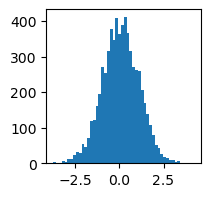

In [70]:
plt.figure(figsize=(2,2))
plt.hist(pretanh.view(-1).data,50);

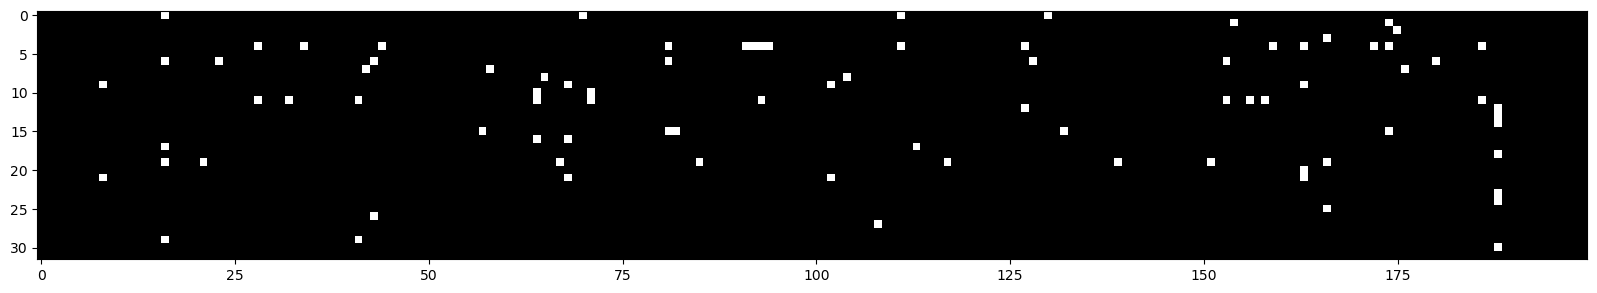

In [65]:
plt.figure(figsize=(20,10))
plt.imshow(abs(h)>0.99,cmap="gray")

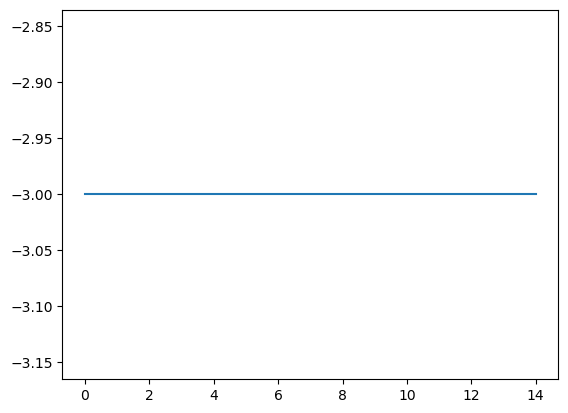

In [44]:
x,y=torch.histogram(torch.tensor([1., 2, 1]), bins=4, range=(0., 3.), weight=torch.tensor([1., 2., 4.]))
# x,y
plt.plot([0,len([1,2,3,4,5,6,7,8,9,0,0,0,0,0,])],[-3,-3])